# 50. データの入手・整形

News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．  

ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．  
情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．  
抽出された事例をランダムに並び替える．  
抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．  

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．  

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [8]:
#データを読み込む
df = pd.read_csv('newsCorpora.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

df.head(3)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550


In [9]:
#データを抽出する
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']),["CATEGORY", "TITLE"]]

df.head(3)

,CATEGORY,TITLE
12,b,Europe reaches crunch point on banking union
13,b,ECB FOCUS-Stronger euro drowns out ECB's messa...
19,b,"Euro Anxieties Wane as Bunds Top Treasuries, S..."


In [10]:
#データを分割する
#train : valid,test = 8:2
train, valid_test = train_test_split(df, test_size = 0.2, shuffle=True, random_state=0, stratify=df['CATEGORY'])
#valid,test を半分に分ける　8:1:1にする
valid, test = train_test_split(valid_test, test_size = 0.5, shuffle=True, random_state=0, stratify=valid_test['CATEGORY'])
#引数stratifyに均等に分割させたいデータ（多くの場合は正解ラベル）を指定すると、そのデータの値の比率が一致するように分割される。

In [11]:
#データを各ファイルに保存する
train.to_csv('./train.txt', sep='\t', index=False)
valid.to_csv('./valid.txt', sep='\t', index=False)
test.to_csv('./test.txt', sep='\t', index=False)

In [12]:
#各カテゴリの事例数を確認
print('train.txt')
print(train['CATEGORY'].value_counts())
print('valid.txt')
print(valid['CATEGORY'].value_counts())
print('test.txt')
print(test['CATEGORY'].value_counts())

train.txt
b    4502
e    4223
t    1219
m     728
Name: CATEGORY, dtype: int64
valid.txt
b    562
e    528
t    153
m     91
Name: CATEGORY, dtype: int64
test.txt
b    563
e    528
t    152
m     91
Name: CATEGORY, dtype: int64


# 51. 特徴量抽出

学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [13]:
#データの前処理
import string
import re

def preprocessing(text):
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(table)  # 記号をスペースに置換
    text = text.lower()  # 小文字にする
    
    return text

In [14]:
# データの結合
df = pd.concat([train, valid, test], axis=0)

df.reset_index(drop=True, inplace=True)  
#元のindexを削除: 引数drop
#元のオブジェクトを変更: 引数inplace

In [15]:
# データの前処理
df['TITLE'] = df['TITLE'].map(lambda x: preprocessing(x))

In [16]:
#特徴量はTF-IDFを採用してみる
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

# データの分割
train_valid = df[:len(train) + len(valid)]
test = df[len(train) + len(valid):]

stopwords = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=3)#出現数が少ない単語は省く

X_train_valid = vectorizer.fit_transform(train_valid['TITLE'])  
X_test = vectorizer.transform(test['TITLE']) 
#fit_transform(): 入力が文書群，出力がtf-idf行列

#DataFrame型に変換
X_train_valid = pd.DataFrame(X_train_valid.toarray(), columns=vectorizer.get_feature_names())
X_test = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names())

# trainとvalidを分割
X_train = X_train_valid[:len(train)]
X_valid = X_train_valid[len(train):]

In [17]:
# データの保存
X_train.to_csv('train.feature.txt', sep='\t', index=False)
X_valid.to_csv('valid.feature.txt', sep='\t', index=False)
X_test.to_csv('test.feature.txt', sep='\t', index=False)

In [18]:
X_train.head()

,10,100,1000,101,106,11,110,111,113,114,...,zebra,zendaya,zeppelin,zero,zillow,zip,zombie,zone,zuckerberg,zynga
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 52. 学習

51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [19]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0,max_iter=1000)
model.fit(X_train, train['CATEGORY'])
#fitメソッドで重みを学習

LogisticRegression(max_iter=1000, random_state=0)

# 53. 予測

52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [20]:
def predict_score(model, x):
    pred = model.predict(x)
    score = np.max(model.predict_proba(x), axis=1)
    return pred, score

In [21]:
train_pred, train_score = predict_score(model, X_train)
valid_pred, valid_score= predict_score(model, X_valid)
test_pred, test_score = predict_score(model, X_test)

print(train_pred, train_score)
print(valid_pred, valid_score)
print(test_pred, test_score)

['b' 'b' 'e' ... 'b' 'b' 'e'] [0.5921797  0.94533437 0.66499234 ... 0.81328431 0.98020163 0.6971796 ]
['b' 'b' 'b' ... 'b' 'e' 'b'] [0.55112997 0.99325897 0.8464743  ... 0.8297711  0.75517679 0.51722426]
['e' 'b' 'e' ... 'm' 't' 'b'] [0.88561333 0.55824137 0.98404448 ... 0.3870971  0.711528   0.86037706]


# 54. 正解率の計測

52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [22]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(train['CATEGORY'], train_pred)
test_accuracy = accuracy_score(test['CATEGORY'], test_pred)

print('学習データの正解率：' + str(train_accuracy))
print('評価データの正解率：' + str(test_accuracy))

学習データの正解率：0.947151424287856
評価データの正解率：0.8868065967016492


# 55. 混同行列の作成

52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [23]:
from sklearn.metrics import confusion_matrix

train_cm = confusion_matrix(train['CATEGORY'], train_pred)
print(train_cm)

[[4413   44    4   41]
 [  28 4188    2    5]
 [  77  113  534    4]
 [ 144   99    3  973]]


In [24]:
test_cm = confusion_matrix(test['CATEGORY'], test_pred)
print(test_cm)

[[531  23   1   8]
 [  8 520   0   0]
 [ 21  22  47   1]
 [ 41  26   0  85]]


# 56. 適合率，再現率，F1スコアの計測

52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

https://qiita.com/FukuharaYohei/items/be89a99c53586fa4e2e4

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_scores(y_true, y_pred):
  # 適合率
    precision = precision_score(test['CATEGORY'], test_pred, average=None, labels=['b', 'e', 't', 'm'])
    precision = np.append(precision, precision_score(y_true, y_pred, average='micro')) 
    precision = np.append(precision, precision_score(y_true, y_pred, average='macro')) 

  # 再現率
    recall = recall_score(test['CATEGORY'], test_pred, average=None, labels=['b', 'e', 't', 'm'])
    recall = np.append(recall, recall_score(y_true, y_pred, average='micro'))
    recall = np.append(recall, recall_score(y_true, y_pred, average='macro'))

  # F1スコア
    f1 = f1_score(test['CATEGORY'], test_pred, average=None, labels=['b', 'e', 't', 'm'])
    f1 = np.append(f1, f1_score(y_true, y_pred, average='micro'))
    f1 = np.append(f1, f1_score(y_true, y_pred, average='macro'))

  # 結果を結合、データフレーム化
    scores = pd.DataFrame({'適合率': precision, '再現率': recall, 'F1スコア': f1},
                        index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])

    return scores

In [26]:
print(calculate_scores(test['CATEGORY'], test_pred))

             適合率       再現率     F1スコア
b       0.883527  0.943162  0.912371
e       0.879865  0.984848  0.929401
t       0.904255  0.559211  0.691057
m       0.979167  0.516484  0.676259
マイクロ平均  0.886807  0.886807  0.886807
マクロ平均   0.911704  0.750926  0.802272


# 57. 特徴量の重みの確認

52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [27]:
features = X_train.columns.values
index = [i for i in range(1, 11)]
for c, coef in zip(model.classes_, model.coef_):
    print(f'カテゴリ：{c}')
    best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['重みの高い特徴量トップ10'], index=index).T
    worst10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=['重みの低い特徴量トップ10'], index=index).T
    display(pd.concat([best10, worst10], axis=0))

カテゴリ：b


,1,2,3,4,5,6,7,8,9,10
重みの高い特徴量トップ10,fed,stocks,china,bank,ecb,update,euro,ukraine,dollar,profit
重みの低い特徴量トップ10,ebola,video,apple,facebook,kardashian,google,microsoft,heart,star,virus


カテゴリ：e


,1,2,3,4,5,6,7,8,9,10
重みの高い特徴量トップ10,kardashian,chris,kim,miley,cyrus,star,movie,paul,film,thrones
重みの低い特徴量トップ10,update,us,google,china,study,gm,facebook,ceo,may,apple


カテゴリ：m


,1,2,3,4,5,6,7,8,9,10
重みの高い特徴量トップ10,ebola,study,fda,cancer,mers,drug,could,cases,health,heart
重みの低い特徴量トップ10,gm,facebook,apple,climate,sales,ceo,deal,twitter,fed,amazon


カテゴリ：t


,1,2,3,4,5,6,7,8,9,10
重みの高い特徴量トップ10,google,facebook,apple,microsoft,climate,gm,nasa,tesla,heartbleed,fcc
重みの低い特徴量トップ10,stocks,fed,shares,cancer,ecb,american,drug,percent,ukraine,kardashian


# 58. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [38]:
from tqdm import tqdm

result = []
for C in tqdm(np.logspace(-5, 5, 11, base=10)): # 10^-5 ~ 10^5 までの11個
    # モデルの学習
    lg = LogisticRegression(random_state=0, max_iter=10000, C=C)
    lg.fit(X_train, train['CATEGORY'])

    # 予測値の取得
    train_pred, train_score = predict_score(lg, X_train)
    valid_pred, vaild_score = predict_score(lg, X_valid)
    test_pred, test_score = predict_score(lg, X_test)

  # 正解率
    train_accuracy = accuracy_score(train['CATEGORY'], train_pred)*100
    valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred)*100
    test_accuracy = accuracy_score(test['CATEGORY'], test_pred)*100

  # 結果の格納
    result.append([C, train_accuracy, valid_accuracy, test_accuracy])

100%|██████████| 11/11 [07:45<00:00, 42.34s/it] 


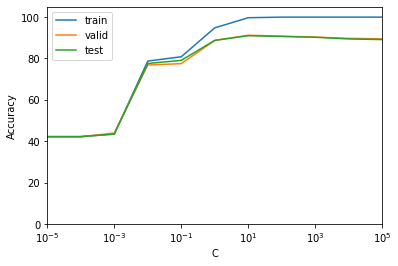

In [45]:
import matplotlib.pyplot as plt

result = np.array(result).T
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.xlim(1e-5, 1e+5)
plt.ylim(0, 105)
plt.ylabel('Accuracy')
plt.xscale ('log') #x軸をlogスケールに
plt.xlabel('C')
plt.legend()

# 59. ハイパーパラメータの探索

学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [28]:
import itertools

def calc_scores(C,solver):
    clf = LogisticRegression(C=C, solver=solver, max_iter=50000)
    clf.fit(X_train, train['CATEGORY'])

    y_train_pred = clf.predict(X_train)
    y_valid_pred = clf.predict(X_valid)
    y_test_pred = clf.predict(X_test)
    
    scores = []
    scores.append(accuracy_score(train['CATEGORY'], y_train_pred))
    scores.append(accuracy_score(valid['CATEGORY'], y_valid_pred))
    scores.append(accuracy_score(test['CATEGORY'], y_test_pred))
    return scores

In [29]:
C = np.logspace(-3, 3, 7, base=10)
solver = ['newton-cg','lbfgs','liblinear','sag','saga']
# class_weight = [None, 'balanced']
best_parameter = None
best_scores = None
max_valid_score = 0
for c, s in itertools.product(C, solver):
    print(c, s)
    scores = calc_scores(c, s)
    if scores[1] > max_valid_score:
        max_valid_score = scores[1]
        best_parameter = [c, s]
        best_scores = scores
print ('best patameter: ', best_parameter)
print ('best scores: ', best_scores)
print ('test accuracy: ', best_scores[2])

0.001 newton-cg
0.001 lbfgs
0.001 liblinear
0.001 sag
0.001 saga
0.01 newton-cg
0.01 lbfgs
0.01 liblinear
0.01 sag
0.01 saga
0.1 newton-cg
0.1 lbfgs
0.1 liblinear
0.1 sag
0.1 saga
1.0 newton-cg
1.0 lbfgs
1.0 liblinear
1.0 sag
1.0 saga
10.0 newton-cg
10.0 lbfgs
10.0 liblinear
10.0 sag
10.0 saga
100.0 newton-cg
100.0 lbfgs
100.0 liblinear
100.0 sag
100.0 saga
1000.0 newton-cg
1000.0 lbfgs
1000.0 liblinear
1000.0 sag
1000.0 saga
best patameter:  [10.0, 'liblinear']
best scores:  [0.9912856071964018, 0.9160419790104948, 0.9092953523238381]
test accuracy:  0.9092953523238381
